# Exploratory Data Analysis
---  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn
import datetime
import statsmodels.api as sm

from pylab import rcParams

In [2]:
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import matplotlib.style as style 

style.use('seaborn-darkgrid')
sns.set_context('notebook')
sns.set_palette('husl')

In [5]:
test = pd.read_csv('wrangled_data/testing_post_wrangle.csv', 
                       dtype={'shop_id':'int8', 
                            'item_id':'int16',
                            'year':'int16',
                            'month':'int8',
                            'date_block_num':'int8',
                            'mean_item':'float64',
                            'mode_item':'float64'})

train = pd.read_csv('wrangled_data/training_post_wrangle_small.csv', 
                       dtype={'shop_id':'int8', 
                            'item_id':'int16',
                            'year':'int16',
                            'month':'int8',
                            'item_cnt_month':'int32',
                            'date_block_num':'int8',
                            'mean_item':'float64',
                            'mode_item':'float64'})

In [6]:
train.shape

(7282800, 13)

In [7]:
train.head(3)

,ID,shop_id,item_id,year,month,item_cnt_month,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,2013,2,0,1,0.382353,0.0,1195,19,11,3
1,0,5,5037,2013,1,0,0,0.382353,0.0,1195,19,11,3
2,0,5,5037,2013,6,0,5,0.382353,0.0,1195,19,11,3


In [8]:
test.shape

(214200, 12)

In [9]:
test.head(3)

,ID,shop_id,item_id,month,year,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,11,2015,34,0.382353,0.0,5036,19,19,5
1,1,5,5320,11,2015,34,0.000000,0.0,5319,55,55,5
2,2,5,5233,11,2015,34,0.294118,0.0,5232,19,19,5


### Time Series Analysis

In [10]:
train['date'] = pd.to_datetime(train[['year', 'month']].assign(DAY=1)).apply(lambda x: x.strftime('%Y-%m'))
# train.drop(columns=['year', 'month'], inplace=True)

In [11]:
train.index = train['date']

In [12]:
train[(train['shop_id'] == 2)].groupby('item_id')['item_cnt_month'].sum().sort_values(ascending=False).head()

item_id
20949    1319
3732      239
17717     222
6675      213
4872      196
Name: item_cnt_month, dtype: int32

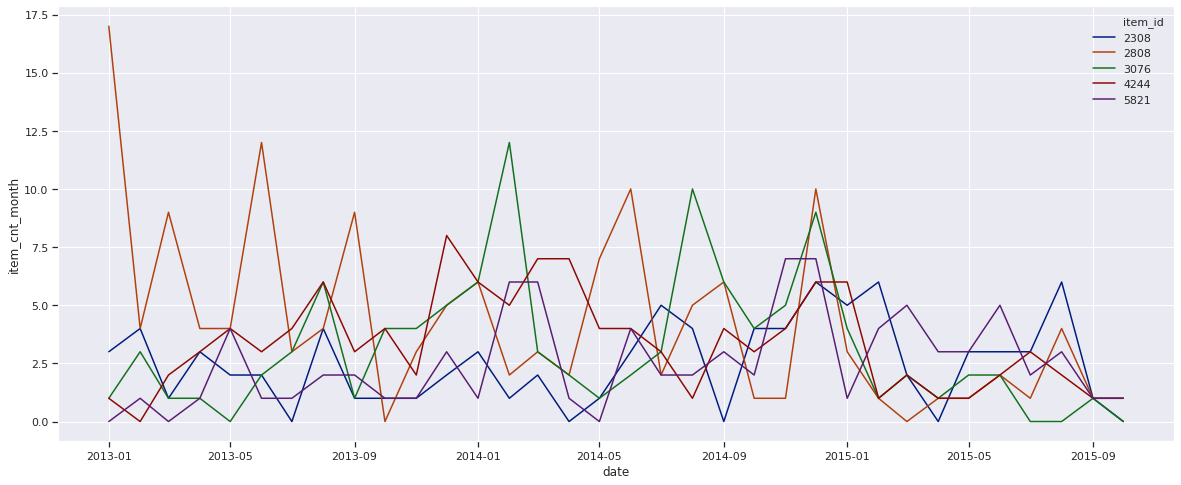

In [13]:
plt.figure(figsize=(20,8))

shop = train[(train['shop_id'] == 2)]
shop = shop[shop['item_id'].isin([4244, 2808, 5821, 3076, 2308])] 
shop = shop.set_index(pd.DatetimeIndex(shop['date']))
shop.drop(columns=['date'], inplace=True)
sns.lineplot(data=shop, x=shop.index, y='item_cnt_month', hue='item_id', palette='dark')

In [14]:
returns = shop[shop['item_id']==5821]['item_cnt_month'].pct_change()
autocorrelation = returns.autocorr()
print("The autocorrelation of items sold each month is %4.2f" %(autocorrelation))

The autocorrelation of items sold each month is  nan


In [15]:
returns = shop[shop['item_id']==5821]['item_cnt_month'].diff()
autocorrelation = returns.autocorr()
print("The autocorrelation of items sold each month is %4.2f" %(autocorrelation))

The autocorrelation of items sold each month is -0.51


In [16]:
resample = shop[shop['item_id']==5821].resample('Y')['item_cnt_month'].mean().reset_index().rename(columns={'item_cnt_month':'year_mean'})
resample['year'] = resample['date'].dt.year
resample.drop(columns=['date'], inplace=True)

ret = pd.merge(shop[shop['item_id']==5821].reset_index(), resample, how='left', on='year')
ret.index = ret['date']
ret.sort_index(inplace=True, ascending=True)
# ret.drop(columns=['date'], inplace=True)

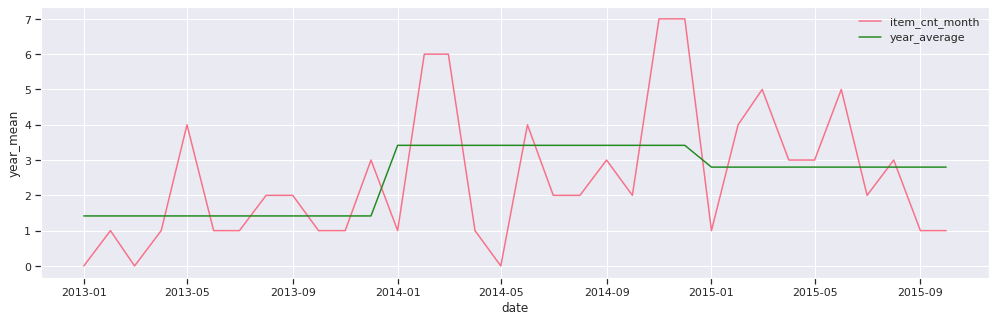

In [17]:
plt.figure(figsize=(17,5))

sns.lineplot(data=ret, x='date', y='item_cnt_month')
sns.lineplot(data=ret, x='date', y='year_mean', color='forestgreen')
plt.legend(['item_cnt_month', 'year_average'])

In [18]:
# v = int(len(ret)/4) if 0 != 0 else 1

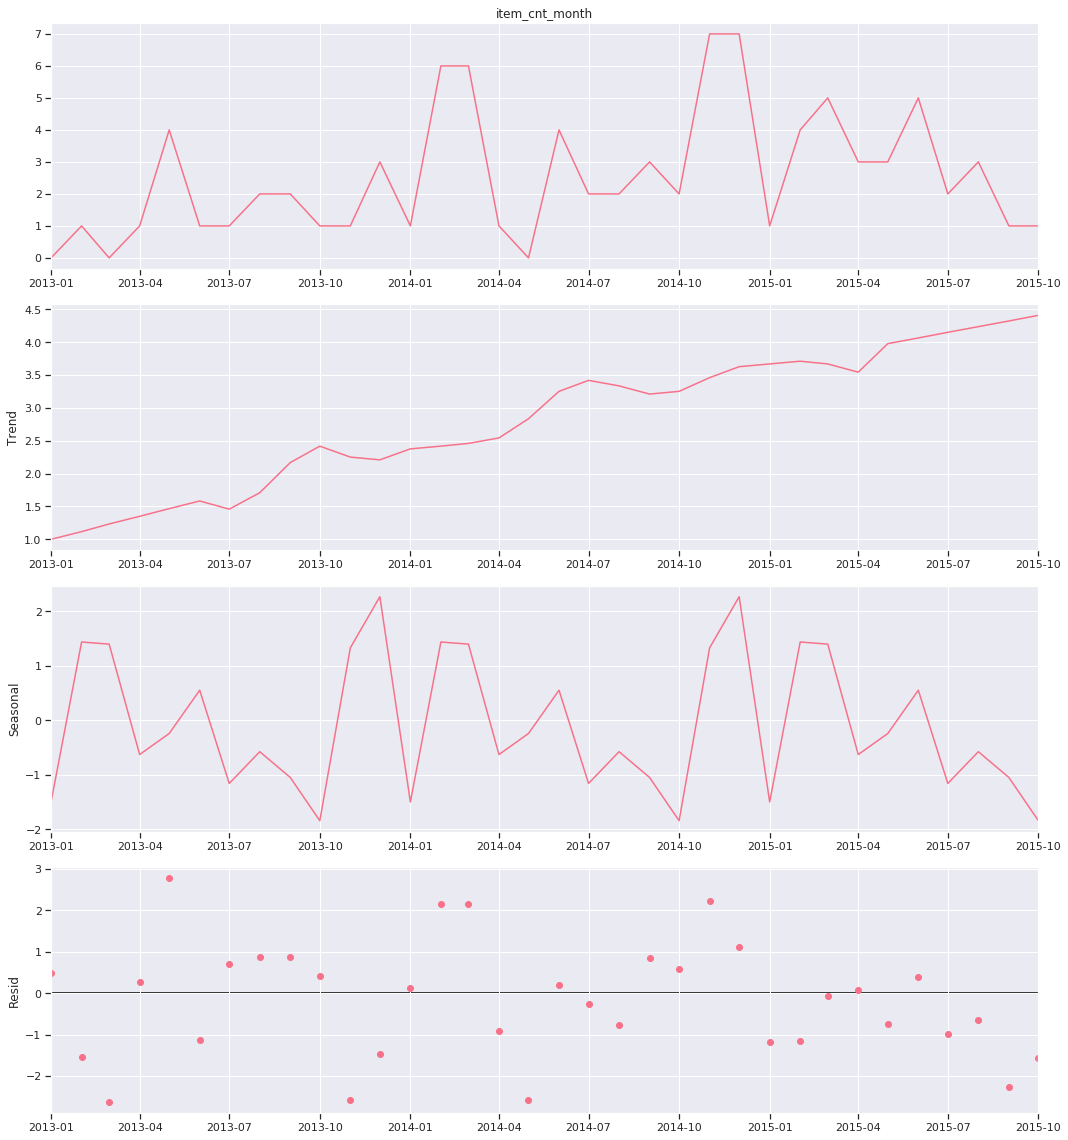

In [19]:
rcParams['figure.figsize'] = 15, 16

decomposition = sm.tsa.seasonal_decompose(ret['item_cnt_month'], model='additive', extrapolate_trend='freq', period=12)
decomposition.plot()
plt.show()

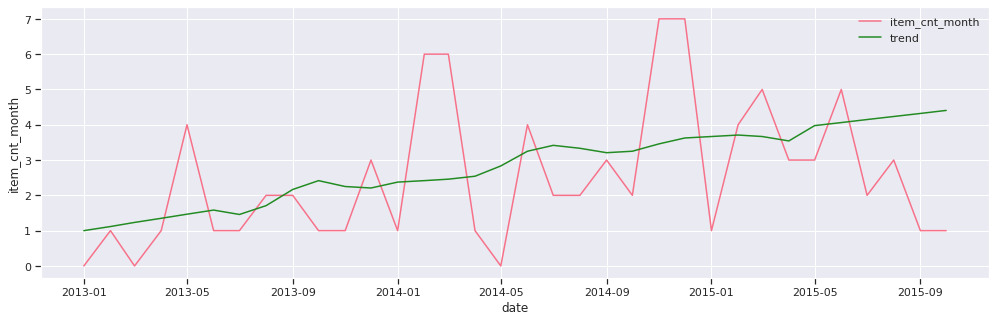

In [20]:
plt.figure(figsize=(17,5))
sns.lineplot(data=ret, x='date', y='item_cnt_month')
plt.plot(decomposition.trend, color='forestgreen')
plt.legend(['item_cnt_month', 'trend'])

In [21]:
train.sort_index(inplace=True, ascending=True)

In [23]:
train.shape

(7282800, 14)

In [24]:
ret['item_cnt_month'].tail(2)

date
2015-09-01    1
2015-10-01    1
Name: item_cnt_month, dtype: int32

In [25]:
train.head(2)

,ID,shop_id,item_id,year,month,item_cnt_month,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name,date
date,,,,,,,,,,,,,,
2013-01,42149,28,18910,2013,1,0,0,1.294118,0.0,4417,40,30,18,2013-01
2013-01,209561,45,21364,2013,1,0,0,0.441176,0.0,4937,40,30,29,2013-01


---  
---  
### Time Series Decomposition

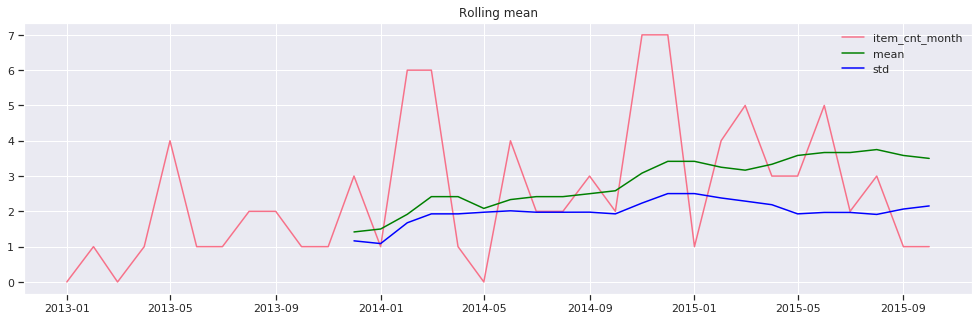

In [26]:
plt.figure(figsize=(17,5))
plt.plot(ret['item_cnt_month'])
plt.plot(ret['item_cnt_month'].rolling(window = 12).mean().dropna(), color='g')
plt.plot(ret['item_cnt_month'].rolling(window = 12).std().dropna(), color='blue')
plt.title('Rolling mean')
plt.legend(['item_cnt_month', 'mean', 'std'])

In [27]:
arima_model = ARIMA(ret['item_cnt_month'][:-4], order=(0,0,2)).fit(transparams=False)
pred = arima_model.predict('2015-07-01', '2015-10-01', typ='levels')
arima_model.summary()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         item_cnt_month   No. Observations:                   30
Model:                     ARMA(0, 2)   Log Likelihood                 -61.457
Method:                       css-mle   S.D. of innovations              1.863
Date:                Mon, 28 Dec 2020   AIC                            130.914
Time:                        09:20:07   BIC                            136.518
Sample:                    01-01-2013   HQIC                           132.707
                         - 06-01-2015                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.6422      0.422      6.264      0.000       1.816       3.469
ma.L1.item_cnt_month     0.4384      0.171      2.560      0.010       0.103       0.774
ma.L2.item_cnt_month    -0.1975      0.148     -1.332      0.183      -0.488       0.093
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.3991           +0.0000j            1.3991            0.5000
MA.2            3.6189           +0.0000j            3.6189            0.0000
-----------------------------------------------------------------------------
"""

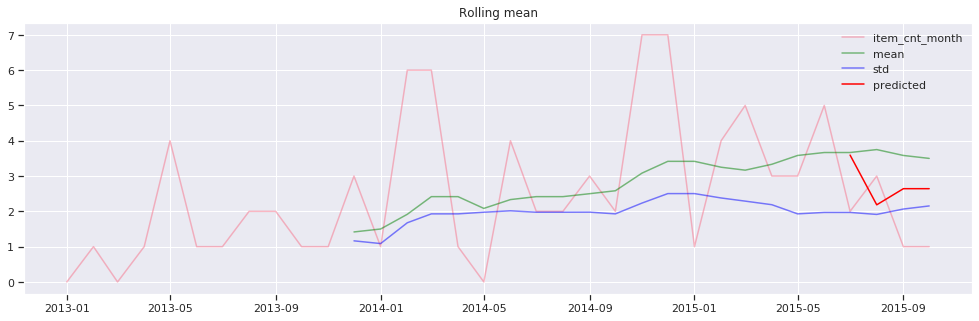

In [28]:
rolling_mean = ret['item_cnt_month'].rolling(window = 12).mean().dropna()
rolling_std = ret['item_cnt_month'].rolling(window = 12).std().dropna()

plt.figure(figsize=(17,5))
plt.plot(ret['item_cnt_month'], alpha=0.5)
plt.plot(rolling_mean, color='g', alpha=0.5)
plt.plot(rolling_std, color='blue', alpha=0.5)

# Predicted 
plt.plot(pred, color='r')
plt.title('Rolling mean')
plt.legend(['item_cnt_month', 'mean', 'std', 'predicted'])

In [29]:
arima_model = ARIMA(rolling_mean[:-4], order=(0,0,3)).fit(transparams=False)
pred_mean = arima_model.predict('2015-07-01', '2015-11-01', typ='levels')

arima_model = ARIMA(rolling_std[:-4], order=(0,0,3)).fit(transparams=False)
pred_std = arima_model.predict('2015-07-01', '2015-11-01', typ='levels')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


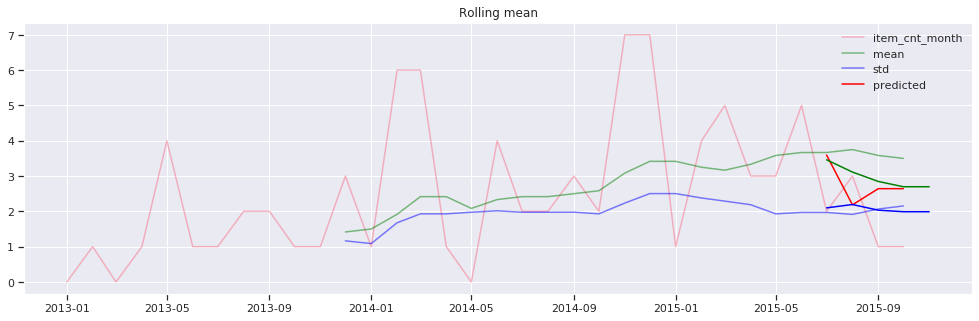

In [30]:
plt.figure(figsize=(17,5))
plt.plot(ret['item_cnt_month'], alpha=0.5)
plt.plot(rolling_mean, color='g', alpha=0.5)
plt.plot(rolling_std, color='blue', alpha=0.5)

# Predicted 
plt.plot(pred, color='r')
plt.plot(pred_mean, color='g')
plt.plot(pred_std, color='b')


plt.title('Rolling mean')
plt.legend(['item_cnt_month', 'mean', 'std', 'predicted'])

---  

In [31]:
test['date'] = pd.to_datetime(test[['year', 'month']].assign(DAY=1)).apply(lambda x: x.strftime('%Y-%m'))
# test.set_index('date', inplace=True)

In [32]:
test['rolling_std'] = np.nan
train['rolling_std'] = np.nan

In [33]:
train.reset_index(drop=True, inplace=True)
train.set_index(['shop_id', 'item_id', 'date'], inplace=True)
train.sort_index(inplace=True)

test.reset_index(drop=True, inplace=True)
test.set_index(['shop_id', 'item_id', 'date'], inplace=True)
test.sort_index(inplace=True)

In [34]:
tmp = train.copy()

tmp = tmp.loc[(slice(0,1), ), :]

In [35]:
key = tmp.groupby(level=[0,1])['item_cnt_month'].sum().index

In [36]:
ind = tmp.groupby(level=2)['item_cnt_month'].sum()

In [37]:
key[:5].values

array([], dtype=object)

In [38]:
ind.head()

Series([], Name: item_cnt_month, dtype: int32)

In [39]:
rolling_std

date
2013-12-01    1.164500
2014-01-01    1.087115
2014-02-01    1.676486
2014-03-01    1.928652
2014-04-01    1.928652
2014-05-01    1.975225
2014-06-01    2.015095
2014-07-01    1.975225
2014-08-01    1.975225
2014-09-01    1.977142
2014-10-01    1.928652
2014-11-01    2.234373
2014-12-01    2.503028
2015-01-01    2.503028
2015-02-01    2.378884
2015-03-01    2.289634
2015-04-01    2.188122
2015-05-01    1.928652
2015-06-01    1.969464
2015-07-01    1.969464
2015-08-01    1.912875
2015-09-01    2.065224
2015-10-01    2.153222
Name: item_cnt_month, dtype: float64

In [40]:
type(eval('(4, 6)'))

tuple

In [41]:
train.loc[key[0], :]['rolling_std'].head()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [40]:
import warnings;
warnings.filterwarnings('ignore');

In [42]:
roll = pd.DataFrame(columns=['shop_id', 'item_id', 'date', 'rolling_std'])
# forecast = pd.DataFrame()

In [43]:
roll.head()

,shop_id,item_id,date,rolling_std


In [ ]:
step_count = 0
for index, new_df in train.groupby(level=[0,1]):

    std = new_df['item_cnt_month'].rolling(window = 12).std()
    std = std.reset_index()
    std = std.rename(columns={'item_cnt_month':'rolling_std'})
    roll = roll.append(std, ignore_index=True)
#     std = std.droplevel(level = [0,1])
    step_count++
    if step_count % 1000 == 0:
        print(step_count)
#     train.loc[index, :]['rolling_std'] = std
#     std.dropna(inplace=True)
#     train.loc[index, :]['rolling_std'].fillna(std[0], inplace=True)




#     arima_model = ARIMA(std, order=(0,0,2)).fit(transparams=False)
#     pred_std_2 = arima_model.predict('2015-11-01', typ='levels')
#     forecast = forecast.append(pred_std_2, ignore_index=True)
#     try:
#         test.loc[index, :]['rolling_std'] = pred_std_2
#     except:
#         continue

In [ ]:

####
# Weighted rolling mean
####
# inx_df[‘adj_close’].ewm().mean()

In [ ]:
train.join(roll.set_index(['shop_id', 'item_id', 'date']), axis=1)

In [ ]:
train = train.join(roll.set_index(['shop_id', 'item_id', 'date']), axis=1)

In [ ]:
train.to_csv('wrangled_data/training_post_eda.csv')

In [ ]:
pred_std_2

In [ ]:
std[0]

In [ ]:
std

In [ ]:
train.loc[(0, 5821), :]['item_cnt_month']

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(train.loc[(0, 5821), :]['item_cnt_month'], alpha=0.5)
# plt.plot(rolling_mean, color='g', alpha=0.5)
# plt.plot(rolling_std, color='blue', alpha=0.5)

# Predicted 
# plt.plot(pred, color='r')
# plt.plot(pred_mean, color='g')
# plt.plot(pred_std, color='b')


# plt.title('Rolling mean')
# plt.legend(['item_cnt_month', 'mean', 'std', 'predicted'])